In [1]:
module('load', 'pytorch/gpu-cuda-12.1/2.2.0')

Loading pytorch/gpu-cuda-12.1/2.2.0
  Loading requirement: cuda/12.1 cudnn/8.9.2


In [5]:
# main_lens_dict={
#     "system_index": 0,
#     "precomputed": {
#         "D_l": 895.141641604983,
#         "D_s": 1719.2297595274565,
#         "D_ls": 1383.4035047295204,
#         "Theta_E": 5.931095815829854e-06
#     },
#     "lens_model": {
#         "num_substructures": 0,
#         "mass_components": [
#             {
#                 "type": "PEMD",
#                 "is_substructure": False,
#                 "params": {
#                     "pos": [
#                         0.0,
#                         0.0
#                     ],
#                     "redshift": 0.27630325852132565,
#                     "vel_disp": 229.76100223115105,
#                     "slope": 0.825713219064535,
#                     "orient": [
#                         1.8219410700100875
#                     ],
#                     "q": [
#                         0.7696236448774971
#                     ]
#                 }
#             }
#         ]
#     },
#     "source_model": {
#         "type": "Gaussian_blob",
#         "params": {
#             "I": 1.0,
#             "position_rad": [
#                 5.7680415247008e-07,
#                 -1.1513580580248836e-07
#             ],
#             "orient_rad": 0.0,
#             "q": 0.8,
#             "std_kpc": 1.4,
#             "redshift": 2.4019740198871116
#         }
#     }
# }


# sub_dict={
#     "type": "NFW",
#     "is_substructure": True,
#     "params": {
#         "pos": [
#             -4.633905994729479e-06,
#             1.0418124529340142e-05
#         ],
#         "mass_max": 99999999999.9998,
#         "r_max_kpc": 3.031994721038995,
#         "redshift": 0.27630325852132565
#     }
# }

main_lens_dict={
    "system_index": 11,
    "precomputed": {
        "D_l": 1787.8262293384223,
        "D_s": 1539.2009840358578,
        "D_ls": 449.9684790307436,
        "Theta_E": 5.954515276371751e-06
    },
    "lens_model": {
        "num_substructures": 0,
        "mass_components": [
            {
                "type": "PEMD",
                "is_substructure": False,
                "params": {
                    "pos": [
                        0.0,
                        0.0
                    ],
                    "redshift": 1.7629021821047843,
                    "vel_disp": 381.676655549674,
                    "slope": 1.1386734630729884,
                    "orient": [
                        0.9017743025951793
                    ],
                    "q": [
                        0.5384704819933674
                    ]
                }
            }
        ]
    },
    "source_model": {
        "type": "Gaussian_blob",
        "params": {
            "I": 1.0,
            "position_rad": [
                5.468951500607737e-07,
                7.709517743986199e-07
            ],
            "orient_rad": 0.0,
            "q": 0.8,
            "std_kpc": 0.8,
            "redshift": 3.534926168256522
        }
    }
}


sub_dict= {
    "type": "NFW",
    "is_substructure": True,
    "params": {
        "pos": [
            9.483614740698115e-06,
            8.167519092202279e-06
        ],
        "mass_max": 2614350859.4532137,
        "r_max_kpc": 3.5158737851037714,
        "redshift": 1.7629021821047843
    }
}

In [2]:
import numpy as np
from shared_utils import units
import astropy.units as u


def get_r_max_from_M_max(M_max):
    M_max=M_max*u.M_sun
    A=0.344*u.kpc #kpc
    B=1.607
    const_1=(np.log(2.163+1.)+1/(2.163+1)-1)*4*np.pi
    #print(const_1)    
    from astropy.constants import G
    G = G.to(u.kpc * u.km**2/u.s**2 / u.M_sun)
    const_2=(10* u.km/u.s     /1.64/np.sqrt(G)   *(2.163/A)**(1/B)    )**2
    #print(const_2)
    r_s=((M_max/const_1/const_2).to(u.kpc**(1 + 2/B)))**(B/(B+2))
    r_max=2.163*r_s
    return r_max.to(u.kpc).value


In [3]:
from lensing_system import LensModel as LensModelNonBatched
from lensing_system_broadcasting import LensModel
from lensing_system_broadcasting import SourceModel
from shared_utils import recursive_to_tensor
import torch
from substructure_classifier.substructure_classifier_development import SubstructureClassifier
from substructure_classifier.training_stage_development import Stage


from shared_utils import _grid_lens
image_grid=_grid_lens(8.0, 500, device="cuda")
eval_grid=_grid_lens(6.0, 80, device="cuda")


loaded_classifier=SubstructureClassifier(classifier_name="EfficientNetB0_low_res4")
classifier_stage=Stage(classifier_instance=loaded_classifier , stage_id="24d1e83d9f0f2f9e004ebe00547854f5111c909eea0a9efc97f9dee5644bc506")

model=classifier_stage.get_model(compiled=True)



cuda
doneStage1
doneStage2
doneStage3
doneStage4
doneStage5
load_stage1
load_stage2
load_stage2.1
load_stage3
load_stage4
load_stage5
load_stage6
doneStage6
doneStage7
EfficientNetB0 is implemented to reshape whatever input size to the arbument target_size. Default 224


done1
done2
tensor(5.9545e-06, device='cuda:0')
done3
done4
done5
torch.Size([16, 500, 500])


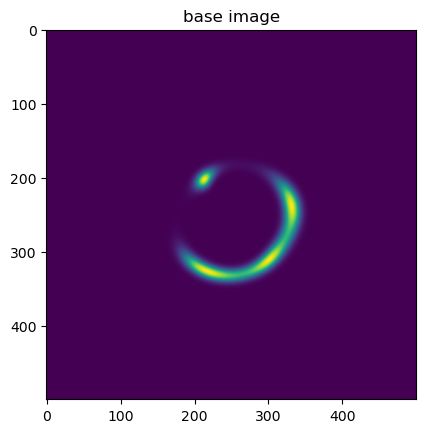

done6


100%|██████████| 5600/5600 [00:48<00:00, 115.33it/s]


In [25]:
import tqdm
import torch.nn.functional as F


from noise_applicator import NoiseApplicator, GaussKernel

class SensMapMaker:
    def __init__(
        self,
        main_lens_dict=main_lens_dict,
        substructure_dict=sub_dict,
        sub_key_changed="mass_max",
        values_key = 10**torch.linspace(7.,11., 14),
        evaluation_grid=eval_grid,
        image_grid=image_grid,
        model=model,
        batch_size=16
    ):
        self.image_grid=image_grid
        self.evaluation_grid=evaluation_grid
        self.batch_size=batch_size
        self.model=model.to("cuda")
        
        print("done1")
        main_lens_dict=recursive_to_tensor(main_lens_dict, device="cuda")
        self.precomp_raw=main_lens_dict["precomputed"] #raw because it will have to be converted to a specific format
        self.source_raw=main_lens_dict["source_model"]
        #1: compute the deflection of the main lens
        main_lens_model = LensModelNonBatched(
            main_lens_dict["lens_model"], 
            precomp_dict=main_lens_dict["precomputed"], 
            device='cuda')
        print("done2")

        self.source_redshift = main_lens_dict["source_model"]["params"]["redshift"]
        self.base_deflection = main_lens_model(image_grid, self.source_redshift).unsqueeze(0).repeat(batch_size, 1, 1, 1)
        print("done3")

        #2: build the systems made of only one sub properly,
        # : we can't built them all toghether with the current lens class.
        # : but I can prepare the batches of initializations, as well as the sub class
        self.sub_raw=sub_dict
        self.set_sub_params_matrix(evaluation_grid, sub_key_changed, values_key)
        #3: build the source properly: since the source is always the same, 
        #   we could keep only one object, with the params and precomp of the fixed size
        #   of the calculation batch.
        print("done4")

        source_data=self.get_source_config(batch_size)
        source_precomp=self.get_expanded_precomp(batch_size)
        
        self.source_model=SourceModel(source_data, source_precomp)
        print("done5")

        image=self.source_model(self.base_deflection)
        print(image.shape)
        import matplotlib.pyplot as plt
        
        plt.imshow(image[0].detach().cpu())
        plt.title("base image")
        plt.show()
            
        print("done6")

        self.get_logits_matrix()
            
    def set_sub_params_matrix(self, evaluation_grid, sub_key_changed, values_key):
        # thi is a matrix of this shape:
        # if n_p is the number of params of the sub, and n_t the nubmer of values tried
        # [n_p, n_t, shape_eval_grid]
        H, W = evaluation_grid.shape[:2]

        self.n_values=n_values=torch.as_tensor(values_key).shape[0]
        sub_param_map={
            'NFW': ['pos_x', 'pos_y','mass_max','r_max_kpc','redshift'],
        }

        sub_type=self.sub_raw["type"]
        sub_params=self.sub_raw["params"]

        if sub_type not in sub_param_map:
            raise NotImplemented

        if sub_type=='NFW':
            init_tensor=torch.tensor([
                sub_params['pos'][0],
                sub_params['pos'][1],
                sub_params['mass_max'],
                sub_params['r_max_kpc'],
                sub_params['redshift'],

            ], device="cuda")
            
            self.n_params=5
            self.sub_type='NFW'
            params_matrix=torch.empty((self.n_params, n_values, evaluation_grid.shape[0], evaluation_grid.shape[1]))
            params_matrix[0, :, :, :]=evaluation_grid[:,:, 0]
            params_matrix[1, :, :, :]=evaluation_grid[:,:, 1]
            params_matrix[2:] = init_tensor[2:, None, None, None].expand(-1, n_values, H, W)
            #now_fill the rest of the matrix
            
            if sub_key_changed=="mass_max":
                # move to the same device/dtype as your params_matrix
                vals = torch.as_tensor(values_key, device=params_matrix.device, dtype=params_matrix.dtype)
                
                value_r_max=torch.as_tensor(get_r_max_from_M_max(values_key), device=params_matrix.device, dtype=params_matrix.dtype)
                # reshape to (n_values, 1, 1)
                vals = vals.view(n_values, 1, 1)
                value_r_max= value_r_max.view(n_values, 1, 1)

                # Option B: explicitly expand to (n_values, H, W)
                vals_expanded = vals.expand(n_values, H, W)
                value_r_max_expanded=value_r_max.expand(n_values, H, W)
                params_matrix[2] = vals_expanded
                params_matrix[3] = value_r_max_expanded

            
            else:
                raise NotImplemented
                
            self.params_matrix=params_matrix


    def get_logits_matrix(self):
        
        #initialize the logits matrix
        all_logits=[]
        bs=self.batch_size
        flat = self.params_matrix.permute(1, 2, 3, 0)  
        flat = flat.reshape(-1, self.n_params)  
        shared_precomp=self.get_expanded_precomp(bs)
        self.model.eval()
        
        H, W = self.evaluation_grid.shape[:2]
        
        tot_im_to_comp=flat.shape[0]
        
        #Noise
        
        sky_level=0.4
        kernel_size=5
        kernel_sigma=1
        gain=1e6
        
        gauss_kernel = GaussKernel(kernel_size, sigma=kernel_sigma, device="cuda").get_kernel()
        self.psf_and_poisson_noise = NoiseApplicator(apply_poisson=True,
                                                    sky_level=sky_level,
                                                    gain=gain,
                                                    psf=gauss_kernel,
                                                    device="cuda")
        
        
        #strategy with last batch:just pad and slice away

        with torch.no_grad():
            for i in tqdm.tqdm(range(0, flat.shape[0], bs)):
                is_last_batch=i+bs> tot_im_to_comp
                if is_last_batch:
                    batch_params = flat[i:i+bs]   
                    cur_bs = batch_params.size(0)
                    last_row = batch_params[-1:]
                    padding  = last_row.expand(bs - cur_bs, -1)
                    batch_params = torch.cat([batch_params, padding], dim=0)
                else:
                    batch_params = flat[i:i+bs]      
                    
                sub_init=self.get_sub_init(batch_params, self.sub_type)
                sub_model=LensModel(
                    bs,
                    sub_init,
                    shared_precomp
                )

                sub_deflection = sub_model.deflection_field(self.image_grid)
                source_grid=self.base_deflection+sub_deflection
                no_noise_image_batch=self.source_model(source_grid).unsqueeze(1)
                
                no_noise_image_batch2=F.avg_pool2d(no_noise_image_batch, kernel_size=5, stride=5)
             

                images= self.psf_and_poisson_noise.apply(no_noise_image_batch2)
    
                max_val = images.amax(dim=(2, 3), keepdim=True).clamp_min(1e-12)
                images = images / max_val

                
                
                
                logits = self.model(images).detach().cpu()         # -> [<=bs, 2]
                if is_last_batch:
                    all_logits.append(logits[:cur_bs])

                else:
                    all_logits.append(logits)

        all_logits = torch.cat(all_logits, dim=0)  # [n_values*H*W, 2]

        
        logits_matrix = all_logits.view(self.n_values, H, W, 2)
        self.logits_matrix = logits_matrix.permute(3, 0, 1, 2)
        
        
    def get_sub_init(self, parameters_batch, sub_type):
        sub_param_map={
            'NFW': ['pos_x', 'pos_y','mass_max','r_max_kpc','redshift'],
        }
        sub_init= {
            sub_type:{
                'sys_idx':   torch.arange(0, parameters_batch.shape[0], device="cuda"),
                'params':    parameters_batch,
                'param_map': sub_param_map[sub_type]
            }
        }
        return sub_init

    

            
    def get_expanded_precomp(self, n_samples):
        precomp_map = ['D_l', 'D_s', 'D_ls', 'Theta_E']
        params=torch.tensor([[
             self.precomp_raw['D_l'], 
             self.precomp_raw['D_s'], 
             self.precomp_raw['D_ls'], 
             self.precomp_raw['Theta_E'] 
        ]], device="cuda")

        precomp_processed = {
            'sys_idx':   torch.arange(0, n_samples, device="cuda"),
            'params': params.repeat(n_samples, 1),
            'param_map': precomp_map
        }

        return precomp_processed


    def get_source_config(self, n_samples):
        source_param_map={
            'Gaussian_blob': ['position_rad_x', 'position_rad_y', 'I' ,'orient_rad','q','std_kpc','redshift']
        }

        source_type=self.source_raw["type"]
        source_params=self.source_raw["params"]

        if source_type not in source_param_map:
            raise NotImplemented

        if source_type=='Gaussian_blob':
            init_tensor=torch.tensor([[
                source_params['position_rad'][0],
                source_params['position_rad'][1],
                source_params['I'],
                source_params['orient_rad'],
                source_params['q'],
                source_params['std_kpc'],
                source_params['redshift'],

            ]], device="cuda")

        source_init={
            source_type: 0
        }
        source_init[source_type] = {
            'sys_idx':   torch.arange(0, n_samples, device="cuda"),
            'params':    init_tensor.repeat(n_samples, 1),
            'param_map': source_param_map[source_type]
        }
        return source_init
    def logits_mat_to_detect_thres(self, confidence):
        pass


a=SensMapMaker()


In [26]:
logits_matr=a.logits_matrix
print(logits_matr.shape)

torch.Size([2, 14, 80, 80])


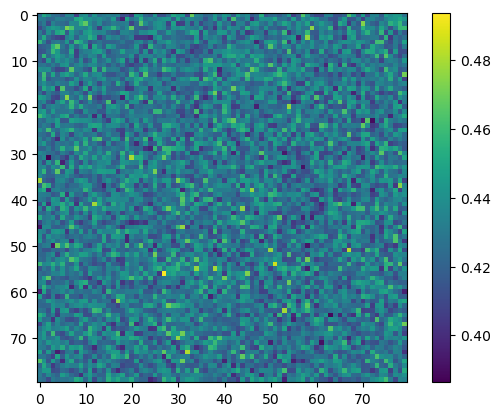

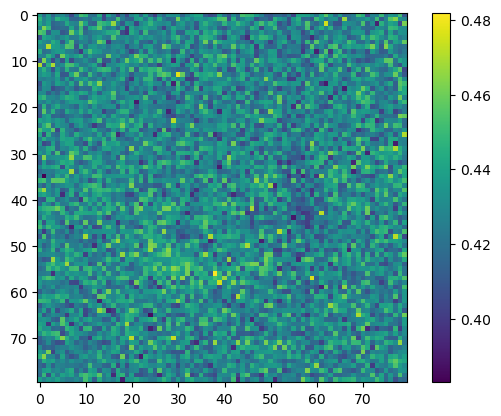

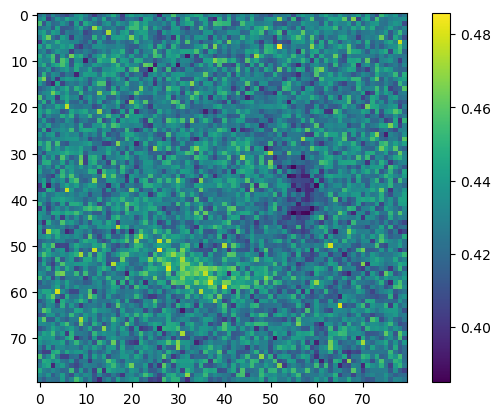

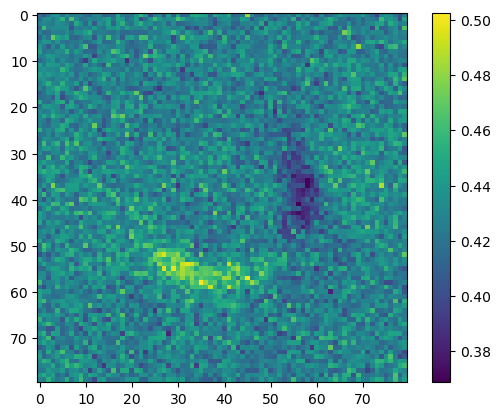

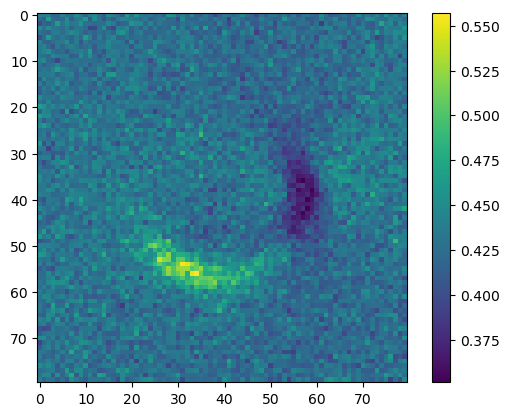

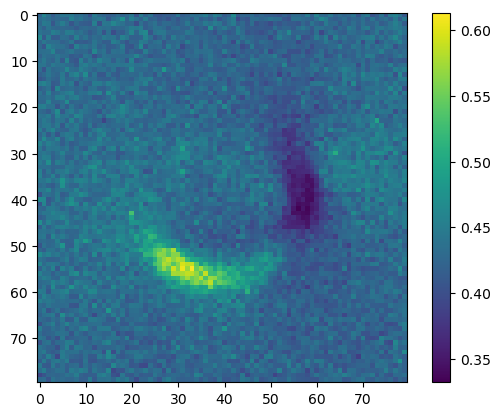

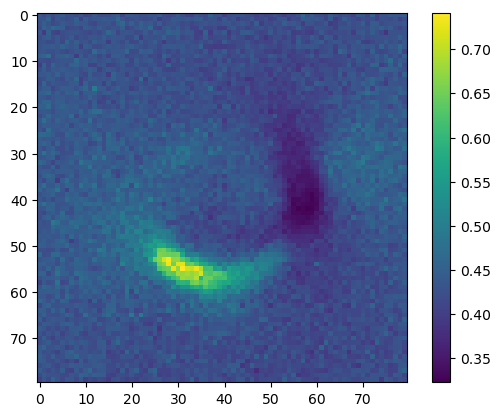

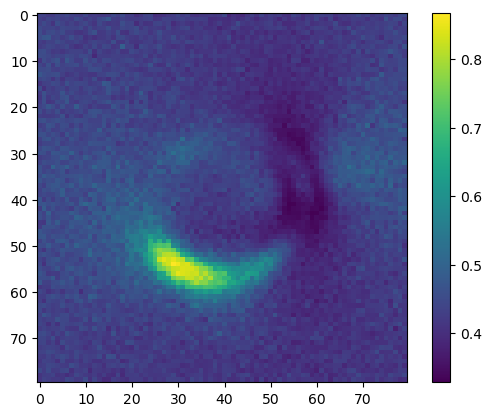

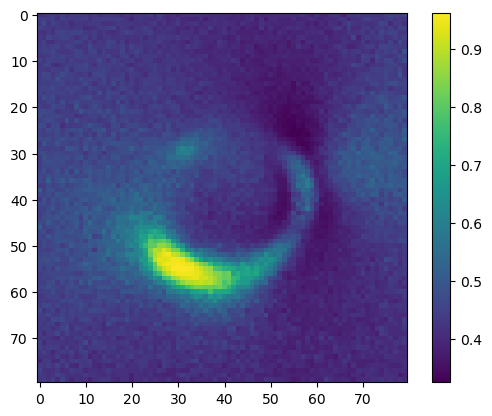

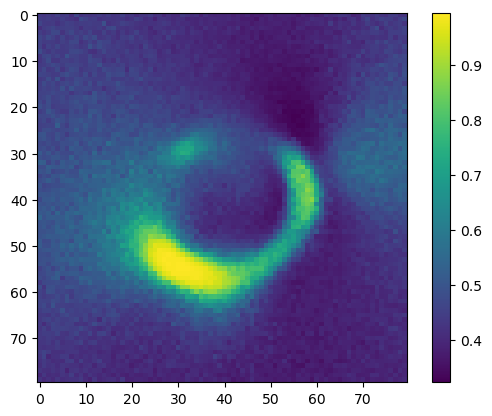

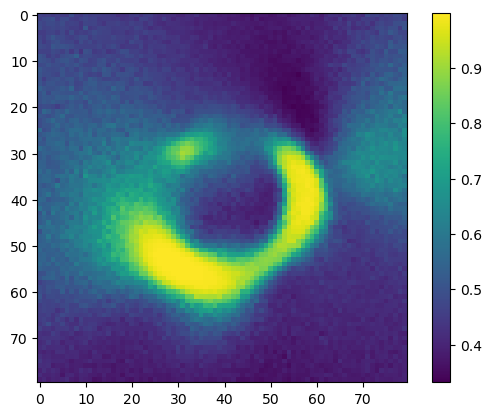

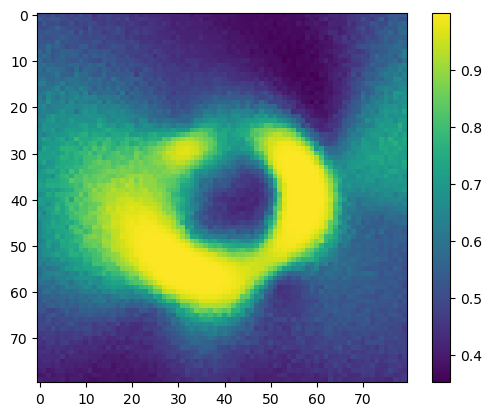

torch.Size([6400, 14])


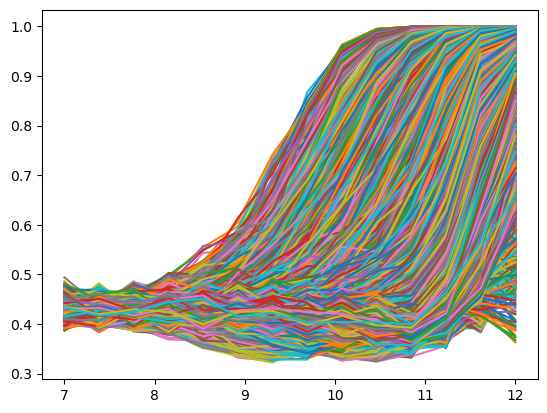

In [27]:
probs=torch.softmax(logits_matr, dim=0)

import matplotlib.pyplot as plt

for i in range(12):
    plt.imshow(probs[1][i])
    plt.colorbar()
    plt.show()
    
prob_pos=probs[1]

prob_pos_flat=prob_pos.permute(1, 2, 0).reshape(-1, 14)
print( prob_pos_flat.shape)

for i in range (prob_pos_flat.shape[0]):
    plt.plot(torch.linspace(7.,12., 14),prob_pos_flat[i])
plt.show()

In [28]:
print(probs.shape)

torch.Size([2, 14, 80, 80])


In [29]:
R=torch.log10(probs[1]/probs[0])

In [30]:
print(R.shape)


torch.Size([14, 80, 80])


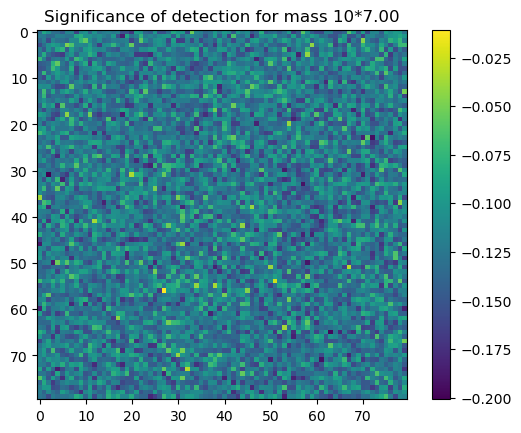

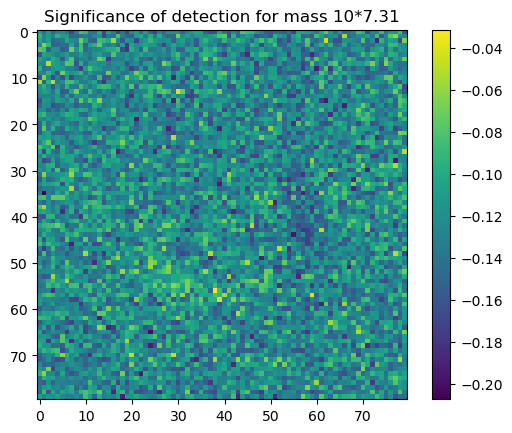

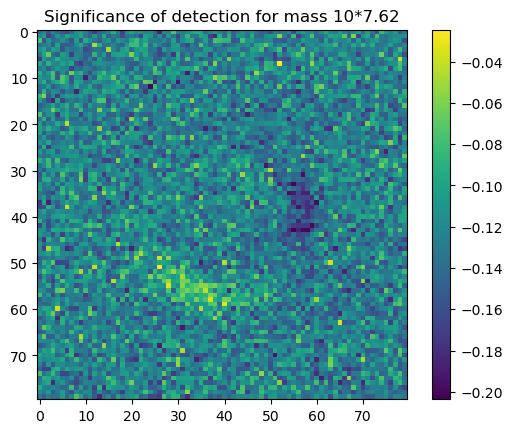

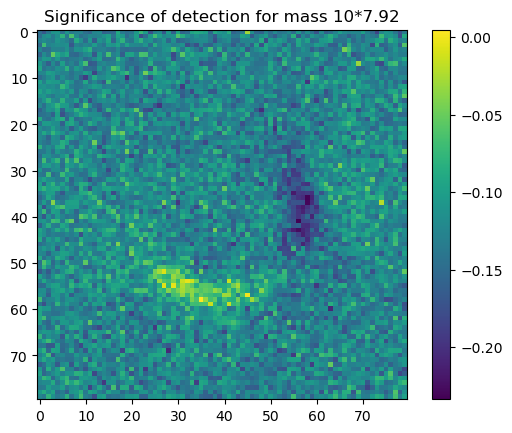

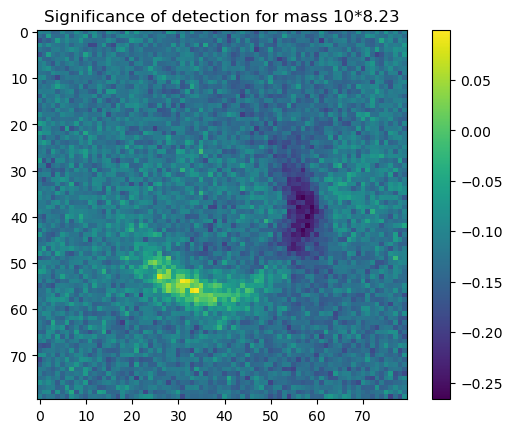

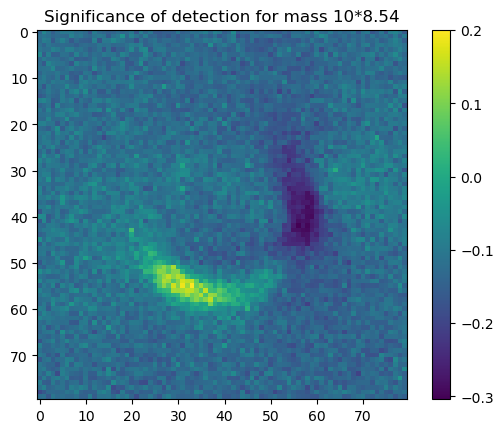

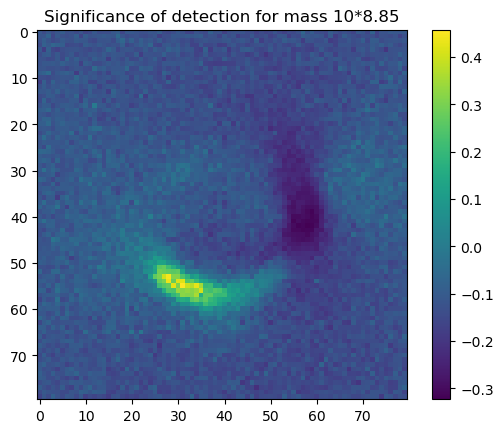

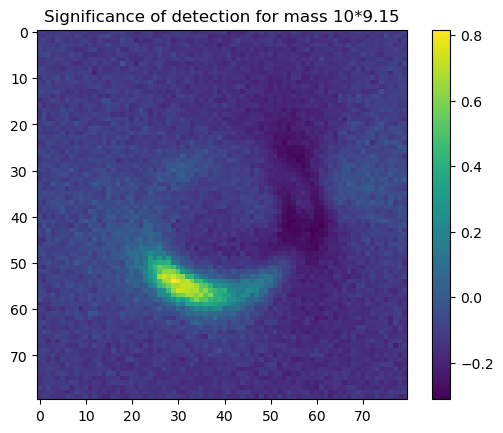

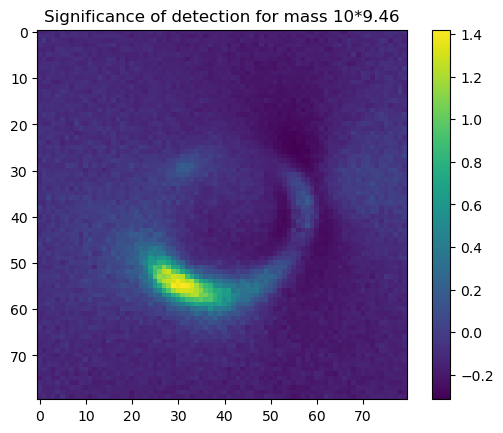

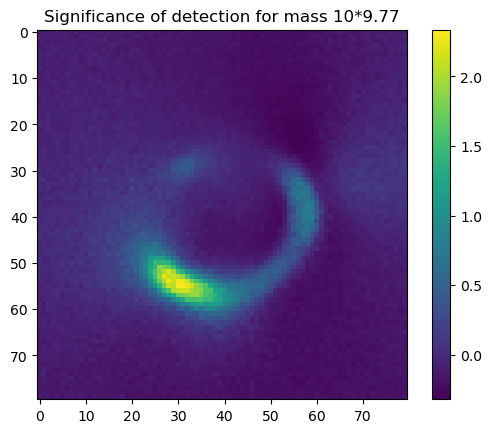

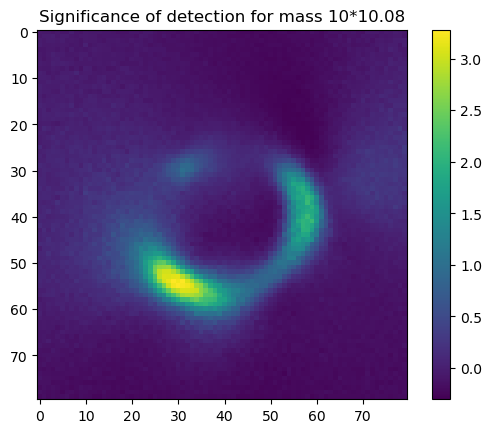

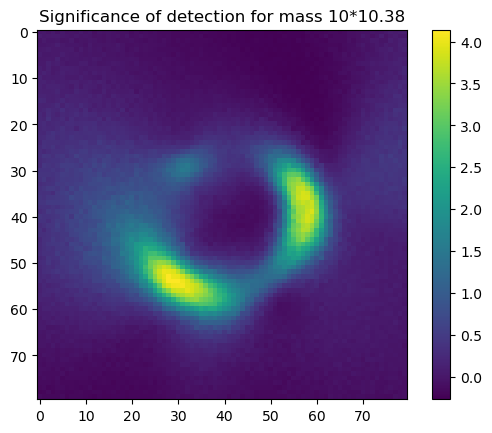

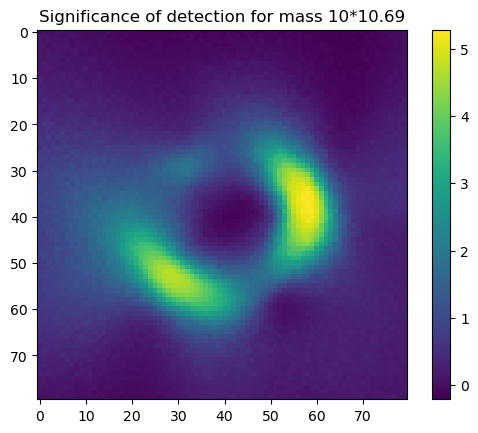

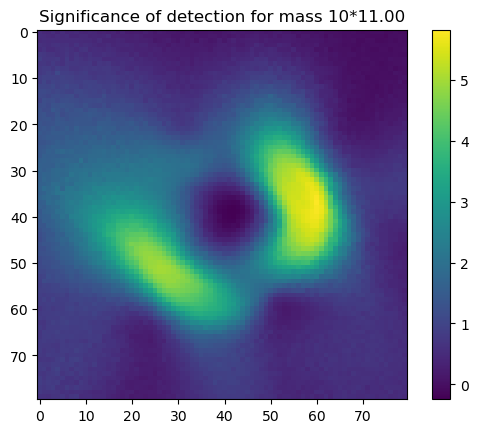

In [31]:
import matplotlib.pyplot as plt

for i in range(14):
    plt.imshow(R[i])
    plt.title(f"Significance of detection for mass 10*{torch.linspace(7.,11., 14)[i]:.2f}")
    plt.colorbar()
    plt.show()

torch.Size([14, 80, 80])


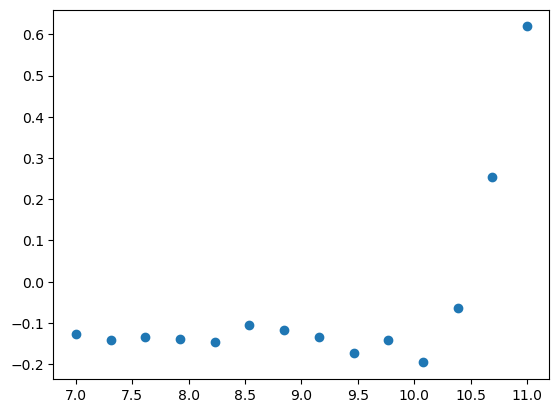

In [32]:
print(R.shape)

masses=torch.linspace(7.,11., 14)

for i in range (1):
    plt.scatter(masses, R[:, 70+i, 50+i])



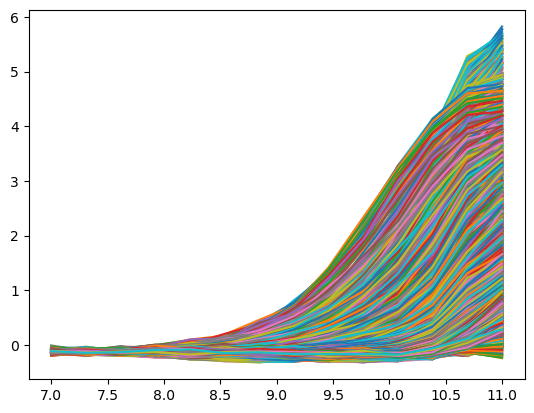

In [33]:
R_flat=R.permute(1, 2, 0).reshape(-1, 14)


for i in range (prob_pos_flat.shape[0]):
    plt.plot(torch.linspace(7.,11., 14),R_flat[i])
plt.show()

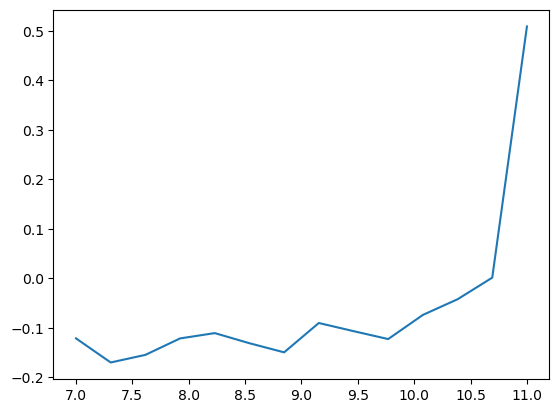

In [34]:
import copy

plt.plot(torch.linspace(7.,11., 14),R_flat[660])

single_curve=copy.deepcopy(R_flat[660])

# Behaviour of the posterior with varying parameters of the relu
### Variationo of a

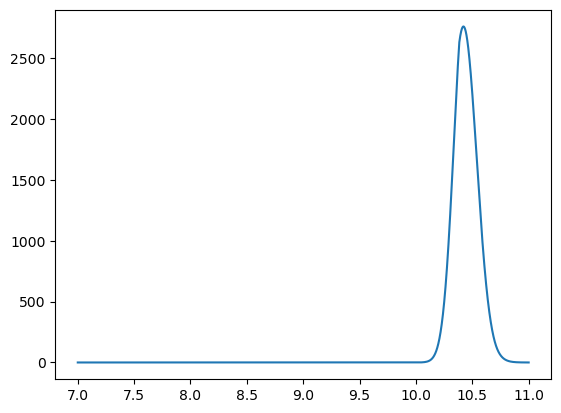

In [35]:
import torch

def log_like(data_x: torch.Tensor,
             data_y: torch.Tensor,
             sigma: float,
             a: float,
             alpha: float) -> torch.Tensor:
    """
    Compute the log-likelihood
        sum_i log [ N(data_y[i] | f(data_x[i]), sigma^2) ]
    where f is a leaky-ReLU with threshold a and slope alpha on the right.
    """
    # f(x) = 0       if x < a
    #      = alpha*(x - a)  if x >= a
    relu = torch.where(
        data_x < a,
        torch.zeros_like(data_x),
        alpha * (data_x - a)
    )

    # constant term: log(1/(sigma*sqrt(2*pi)))
    const = - (torch.log(torch.tensor(sigma)) + 0.5 * torch.log(torch.tensor(2 * torch.pi)))

    # Gaussian log-prob for each point: const - (y - f(x))^2/(2*sigma^2)
    log_probs = const - 0.5 * ((data_y - relu) ** 2) / (sigma ** 2)

    return torch.sum(log_probs)


data_x = torch.linspace(7., 11., 14)
sigma  = 0.1
alpha  = 0.6
a_values= torch.linspace(7., 11., 10000)

likelihoods=torch.zeros_like(a_values)
for i, a  in enumerate(a_values):
    ll = log_like(data_x, single_curve, sigma, a, alpha)
    likelihoods[i]=torch.exp(ll)
    
    
plt.plot(a_values, likelihoods)

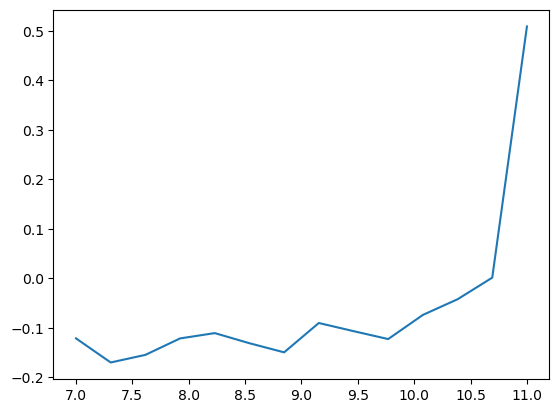

Estimated threshold a = 10.6209
Estimated slope     m = 1.6493
Estimated intercept b = -0.1165


In [36]:
import numpy as np

def fit_relu_mle(x, y):
    """
    Fit the ReLU‐threshold model
       f(x) = b                 for x < a,
            = b + m*(x - a)     for x >= a
    by finding, in each interval (x[i], x[i+1]), the root a* of
      sum_{j: x_j >= a*} [y_j - b(a*) - m(a*)(x_j - a*)] = 0
    (with m(a*) the OLS‐slope on the active set, which is shift‐invariant),
    discarding any root outside its interval, and picking the one
    with minimal total SSE.
    
    Returns
    -------
    a_best, m_best, b_best : float
        The MAP/MLE estimates of (a, m, b).
    """
    x = np.asarray(x)
    y = np.asarray(y)
    # sort data
    idx = np.argsort(x)
    x_s = x[idx]
    y_s = y[idx]
    N = len(x_s)

    # build prefix sums for fast suffix‐sum computation
    ps_x  = np.concatenate(([0.], np.cumsum(x_s)))
    ps_y  = np.concatenate(([0.], np.cumsum(y_s)))
    ps_xy = np.concatenate(([0.], np.cumsum(x_s * y_s)))
    ps_x2 = np.concatenate(([0.], np.cumsum(x_s * x_s)))
    S_tot_y = ps_y[-1]

    best_loss = np.inf
    best_params = (np.nan, np.nan, np.nan)

    # loop over each interval [x_s[i], x_s[i+1]]
    for i in range(N - 1):
        N_less = i + 1
        N_ge   = N - N_less

        # sums over the active set j > i
        S_A_x  = ps_x[-1]  - ps_x[N_less]
        S_A_y  = ps_y[-1]  - ps_y[N_less]
        S_A_xy = ps_xy[-1] - ps_xy[N_less]
        S_A_x2 = ps_x2[-1] - ps_x2[N_less]

        # OLS slope on (x_j, y_j) for j>i  (shift‐invariant)
        denom = N_ge * S_A_x2 - (S_A_x)**2
        if np.isclose(denom, 0):
            continue
        m_i = (N_ge * S_A_xy - S_A_x * S_A_y) / denom

        # closed‐form root for a:
        #   a* = [ S_A_x
        #          - (N * S_A_y - N_ge * S_tot_y) / (m_i * N_less)
        #        ] / N_ge
        if np.isclose(m_i * N_less, 0):
            continue
        a_star = (
            S_A_x
            - (N * S_A_y - N_ge * S_tot_y) / (m_i * N_less)
        ) / N_ge

        # only accept if it really lies in (x_s[i], x_s[i+1])
        if not (x_s[i] < a_star < x_s[i+1]):
            continue

        # profile‐intercept
        b_star = (S_tot_y / N) - (m_i / N) * (S_A_x - N_ge * a_star)

        # compute total SSE
        y_pred = np.where(
            x_s < a_star,
            b_star,
            b_star + m_i * (x_s - a_star)
        )
        sse = np.sum((y_s - y_pred)**2)

        if sse < best_loss:
            best_loss = sse
            best_params = (a_star, m_i, b_star)

    return best_params


# synthetic data
x = data_x
# true params: a=2, m=1.5, b=0.5
y = single_curve
plt.plot(x, y)
plt.show()
a_hat, m_hat, b_hat = fit_relu_mle(x, y)
print(f"Estimated threshold a = {a_hat:.4f}")
print(f"Estimated slope     m = {m_hat:.4f}")
print(f"Estimated intercept b = {b_hat:.4f}")


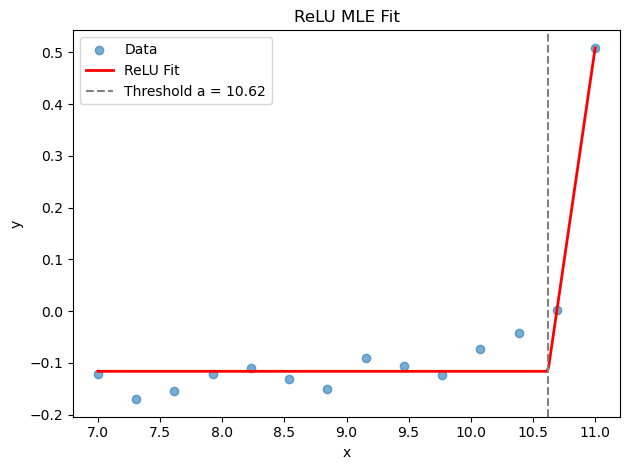

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# assume x, y, a_hat, m_hat, b_hat are already defined
plt.scatter(x, y, alpha=0.6, label='Data')

# fine grid for plotting the fitted curve
x_plot = np.linspace(x.min(), x.max(), 300)
y_plot = np.where(
    x_plot < a_hat,
    b_hat,
    b_hat + m_hat * (x_plot - a_hat)
)

plt.plot(x_plot, y_plot, linewidth=2, label='ReLU Fit', color='red')
plt.axvline(a_hat, linestyle='--', color='gray', label=f'Threshold a = {a_hat:.2f}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('ReLU MLE Fit')
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
import torch

def fit_relu_mle_batch(x: torch.Tensor, Y: torch.Tensor):
    """
    x: (T,)        sorted abscissae
    Y: (T, H, W)   observations per pixel
    returns (A, M, B) each of shape (H, W)
    """
    T, H, W = Y.shape
    device = Y.device

    # 1) prefix sums of x and x^2
    ps_x  = torch.cat([torch.zeros(1, device=device), x.cumsum(0)], dim=0)     # (T+1)
    ps_x2 = torch.cat([torch.zeros(1, device=device), (x*x).cumsum(0)], dim=0) # (T+1)

    # 2) prefix sums of y, y^2, and x*y along dim=0
    Y2 = Y*Y
    XY = x.view(T,1,1) * Y

    ps_y  = torch.cat([torch.zeros(1,H,W,device=device), Y.cumsum(0)],  dim=0)  # (T+1,H,W)
    ps_y2 = torch.cat([torch.zeros(1,H,W,device=device), Y2.cumsum(0)], dim=0)
    ps_xy = torch.cat([torch.zeros(1,H,W,device=device), XY.cumsum(0)], dim=0)

    S_tot_y   = ps_y[-1]   # (H,W)
    S_Y2_tot  = ps_y2[-1]  # (H,W)

    # 3) build interval‐wise scalars (i = 0..T-2)
    i       = torch.arange(0, T-1, device=device)        # (T-1)
    N_less  = (i+1).view(-1,1,1)                         # (T-1,1,1)
    N_ge    = (T - (i+1)).view(-1,1,1)                   # (T-1,1,1)

    S_A_x   = (ps_x[-1]  - ps_x[i+1]).view(-1,1,1)       # (T-1,1,1)
    S_A_x2  = (ps_x2[-1] - ps_x2[i+1]).view(-1,1,1)

    S_A_y   = ps_y[-1].unsqueeze(0)  - ps_y[i+1]         # (T-1,H,W)
    S_A_xy  = ps_xy[-1].unsqueeze(0) - ps_xy[i+1]

    # 4) OLS slope m_i and intercept root‐for‐a
    denom   = N_ge*S_A_x2 - S_A_x**2
    m_i     = (N_ge*S_A_xy - S_A_x*S_A_y) / denom

    a_star  = (
        S_A_x
        - (T*S_A_y - N_ge*S_tot_y) / (m_i * N_less)
    ) / N_ge

    # 5) mask out any a_star outside its [x_i, x_{i+1}] interval
    x_i     = x[:-1].view(-1,1,1)
    x_ip1   = x[1:].view(-1,1,1)
    valid   = (a_star > x_i) & (a_star < x_ip1)

    # 6) corresponding b*
    b_star  = (S_tot_y/T) - (m_i/T)*(S_A_x - N_ge*a_star)

    # 7) assemble SSE in closed form:
    S_A_xy_shift = S_A_xy - a_star*S_A_y
    S_A_x_shift  = S_A_x  - N_ge*a_star
    S_A_shift2   = S_A_x2 - 2*a_star*S_A_x + N_ge*a_star*a_star

    SSE = (
        S_Y2_tot.unsqueeze(0)
        - 2*b_star*S_tot_y.unsqueeze(0)
        - 2*m_i*S_A_xy_shift
        + T*b_star*b_star
        + 2*b_star*m_i*S_A_x_shift
        + (m_i*m_i)*S_A_shift2
    )

    # 8) ignore invalid intervals
    SSE = torch.where(valid, SSE, torch.tensor(float('inf'), device=device))

    # 9) pick best i per pixel
    best_i = SSE.argmin(dim=0)        # (H,W)

    # 10) gather a, m, b at best_i
    grid_h, grid_w = torch.meshgrid(
        torch.arange(H, device=device),
        torch.arange(W, device=device),
        indexing='ij'
    )
    A = a_star[best_i,       grid_h, grid_w]
    M = m_i   [best_i,       grid_h, grid_w]
    B = b_star[best_i,       grid_h, grid_w]

    return A, M, B



In [39]:
import torch

# assume fit_relu_mle_batch is already defined/imported

x = torch.tensor(masses)
Y = R



# 3) fit all pixels in one go
A_hat, M_hat, B_hat = fit_relu_mle_batch(x, Y)          # each is (H,W)

# 4) inspect results
print("shapes:", A_hat.shape, M_hat.shape, B_hat.shape)  # → (64,64) each
print("sample pixel [0,0]:",
      A_hat[0,0].item(),
      M_hat[0,0].item(),
      B_hat[0,0].item())


shapes: torch.Size([80, 80]) torch.Size([80, 80]) torch.Size([80, 80])
sample pixel [0,0]: 10.603429794311523 1.6233891248703003 -0.10907399654388428


/tmp/ipykernel_17192/4280639548.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masses)


mass_thres shape: (80, 80)


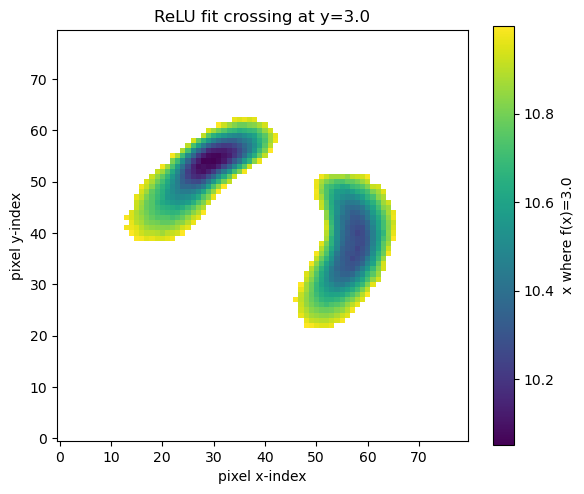

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# assume A_hat, M_hat, B_hat are torch tensors on CPU/GPU
A = A_hat.cpu().numpy()   # shape (H, W)
M = M_hat.cpu().numpy()
B = B_hat.cpu().numpy()

threshold = 3.0

# compute the x at which f(x)=threshold
mass_thres = (threshold - B) / M + A  # shape (H, W)

# build mask: only keep pixels with positive slope and intercept ≤ 1e12
valid = (M > 0) & (mass_thres <= 11)

# set invalid pixels to NaN
mass_thres_masked = mass_thres.copy()
mass_thres_masked[~valid] = np.nan

print("mass_thres shape:", mass_thres_masked.shape)

# plot
plt.figure(figsize=(6,5))
im = plt.imshow(mass_thres_masked, origin='lower', cmap='viridis')
plt.colorbar(im, label=f"x where f(x)={threshold}")
plt.title('ReLU fit crossing at y={}'.format(threshold))
plt.xlabel('pixel x-index')
plt.ylabel('pixel y-index')
plt.tight_layout()
plt.show()
